## Installing and loading libraries

In [1]:
!pip install huggingface_hub(cli)
!pip install utilsforecast
!pip install praxis
!pip install paxml
!pip install jax[cuda12]==0.4.26
!pip install einshape
!pip install timesfm[pax]
!pip install optuna

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install huggingface_hub(cli)'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and pra

In [2]:
import timesfm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
import optuna

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].


## Data loading and preparation

In [4]:
# loading data with yfinance library
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
# making sure we use the same data
df = df.loc[: "2025-06-01"]

df = df[['Close']] # choosing columns we will be using

# creating new index which covers all dates and reindexing our dataframe
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_index)

df['unique_id'] = 'eqr' # column named 'unique_id' is mandatory in TimesFM

# filling the data with forward-fill and renaming columns
df['Close'].fillna(method='ffill', inplace=True)
df = df.reset_index().rename(columns={'index': 'ds', 'Close': 'y'})

df['ds'] = pd.to_datetime(df['ds']) # making sure values in 'ds' column are of type datetime

df.tail(5)

<ipython-input-4-ded6a7b282ed>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].fillna(method='ffill', inplace=True)
<ipython-input-4-ded6a7b282ed>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'].fillna(method='ffill', inplace=True)


,ds,y,unique_id
11610,2025-05-26 00:00:00-04:00,67.610001,eqr
11611,2025-05-27 00:00:00-04:00,68.620003,eqr
11612,2025-05-28 00:00:00-04:00,69.010002,eqr
11613,2025-05-29 00:00:00-04:00,69.980003,eqr
11614,2025-05-30 00:00:00-04:00,70.139999,eqr


In [5]:
# compute split points
n = len(df)
train_end = round(n * 0.7)
valid_end = round(n * 0.9)

# split by position
train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:valid_end]
test_df  = df.iloc[valid_end:]

# sanity check
assert len(train_df) + len(valid_df) + len(test_df) == n

print(test_df.head(5))

                             ds          y unique_id
10454 2022-03-27 00:00:00-04:00  78.885727       eqr
10455 2022-03-28 00:00:00-04:00  79.825066       eqr
10456 2022-03-29 00:00:00-04:00  82.306313       eqr
10457 2022-03-30 00:00:00-04:00  81.083420       eqr
10458 2022-03-31 00:00:00-04:00  79.683289       eqr


In [6]:
start_ts = pd.Timestamp('2022-05-13 00:00:00-0400')

# generating list of 9 dates every 7 days
test_periods = pd.date_range(start=start_ts, periods=9, freq='7d').tolist()

print(test_periods)

[Timestamp('2022-05-13 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-05-20 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-05-27 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-03 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-10 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-17 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-24 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-07-01 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-07-08 00:00:00-0400', tz='UTC-04:00')]


## Hyperparameter tuning with Optuna

In [7]:
# 1. loading checkpoint
checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
)

def objective(trial):
    # 2. proposed hyperparameters
    context_len = trial.suggest_int("context_len", 256, 2048, step=32)
    horizon_len = trial.suggest_int("horizon_len", 16, 128, step=16)
    batch_size  = trial.suggest_categorical("per_core_batch_size", [16,32,64])

    # 3. model initialization
    hparams = timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=batch_size,
        context_len=context_len,
        horizon_len=horizon_len,
        # we're keeping the rest of the architecture unchanged
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
    )
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

    # 4. forecast nad evaluation on first 'horizon_len' days of valid_df
    fc = tfm.forecast_on_df(
        inputs=train_df,
        freq="1D",
        value_name="y",
        num_jobs=-1
    )
    # making sure we perform MAPE calculations on fitting data
    subtest = valid_df.iloc[:horizon_len]
    merged = pd.merge(
        subtest[['ds','y']],
        fc[['ds','timesfm']],
        on='ds', how='inner'
    )
    # safety check
    if len(merged) < horizon_len // 2:
        return float("inf")
    mape = mean_absolute_percentage_error(
        merged['y'].values,
        merged['timesfm'].values
    )
    return mape

# 5. creating Optuna study
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=20)

print("Best MAPE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-08 11:25:55,007] A new study created in memory with name: no-name-332c662f-3834-4628-a257-056e884586f6
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:27:05,927] Trial 0 finished with value: 0.02743113202220774 and parameters: {'context_len': 1568, 'horizon_len': 80, 'per_core_batch_size': 32}. Best is trial 0 with value: 0.02743113202220774.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:27:43,163] Trial 1 finished with value: 0.019959278558405874 and parameters: {'context_len': 960, 'horizon_len': 16, 'per_core_batch_size': 32}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:28:36,947] Trial 2 finished with value: 0.027471112131570923 and parameters: {'context_len': 1088, 'horizon_len': 48, 'per_core_batch_size': 64}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:29:00,813] Trial 3 finished with value: 0.03250910254484465 and parameters: {'context_len': 1472, 'horizon_len': 112, 'per_core_batch_size': 16}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:29:16,452] Trial 4 finished with value: 0.02704950441355296 and parameters: {'context_len': 352, 'horizon_len': 80, 'per_core_batch_size': 32}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:30:44,161] Trial 5 finished with value: 0.031934109977526465 and parameters: {'context_len': 1856, 'horizon_len': 96, 'per_core_batch_size': 64}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:32:02,877] Trial 6 finished with value: 0.027855588851264265 and parameters: {'context_len': 1632, 'horizon_len': 16, 'per_core_batch_size': 64}. Best is trial 1 with value: 0.019959278558405874.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:32:34,502] Trial 7 finished with value: 0.019619796433661917 and parameters: {'context_len': 544, 'horizon_len': 48, 'per_core_batch_size': 64}. Best is trial 7 with value: 0.019619796433661917.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:33:47,319] Trial 8 finished with value: 0.03199526573173547 and parameters: {'context_len': 1568, 'horizon_len': 96, 'per_core_batch_size': 64}. Best is trial 7 with value: 0.019619796433661917.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:34:13,450] Trial 9 finished with value: 0.026472575133610933 and parameters: {'context_len': 448, 'horizon_len': 80, 'per_core_batch_size': 64}. Best is trial 7 with value: 0.019619796433661917.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:34:29,375] Trial 10 finished with value: 0.018231608744234976 and parameters: {'context_len': 832, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 10 with value: 0.018231608744234976.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:34:45,167] Trial 11 finished with value: 0.016139747438393973 and parameters: {'context_len': 736, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 11 with value: 0.016139747438393973.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:35:02,803] Trial 12 finished with value: 0.014681828550643433 and parameters: {'context_len': 800, 'horizon_len': 48, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:35:18,193] Trial 13 finished with value: 0.019189232488702745 and parameters: {'context_len': 736, 'horizon_len': 32, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:35:38,665] Trial 14 finished with value: 0.032304129826334016 and parameters: {'context_len': 1280, 'horizon_len': 64, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:35:54,914] Trial 15 finished with value: 0.01867789621014232 and parameters: {'context_len': 672, 'horizon_len': 32, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:36:04,549] Trial 16 finished with value: 0.04730663823051081 and parameters: {'context_len': 256, 'horizon_len': 128, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:36:25,923] Trial 17 finished with value: 0.027014161041999867 and parameters: {'context_len': 1184, 'horizon_len': 64, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:36:48,333] Trial 18 finished with value: 0.018749167317645837 and parameters: {'context_len': 928, 'horizon_len': 32, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.


[I 2025-06-08 11:37:06,452] Trial 19 finished with value: 0.025770778973635826 and parameters: {'context_len': 608, 'horizon_len': 64, 'per_core_batch_size': 16}. Best is trial 12 with value: 0.014681828550643433.


Finished forecasting.
Best MAPE: 0.014681828550643433
Best params: {'context_len': 800, 'horizon_len': 48, 'per_core_batch_size': 16}


## Rolling window forecast with best hyperparameters

In [8]:
hparams = timesfm.TimesFmHparams(
    backend="gpu",
    per_core_batch_size=study.best_params["per_core_batch_size"],
    context_len=study.best_params["context_len"],
    horizon_len=study.best_params["horizon_len"],
    input_patch_len=32,
    output_patch_len=128,
    num_layers=50,
    model_dims=1280,
    use_positional_embedding=False,
)
tfm_best = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-05-13 – MAPE: 1.41%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-05-20 – MAPE: 1.80%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-05-27 – MAPE: 1.64%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-06-03 – MAPE: 4.28%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-06-10 – MAPE: 2.87%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-06-17 – MAPE: 3.32%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-06-24 – MAPE: 0.62%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-07-01 – MAPE: 0.63%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Window start 2022-07-08 – MAPE: 0.92%


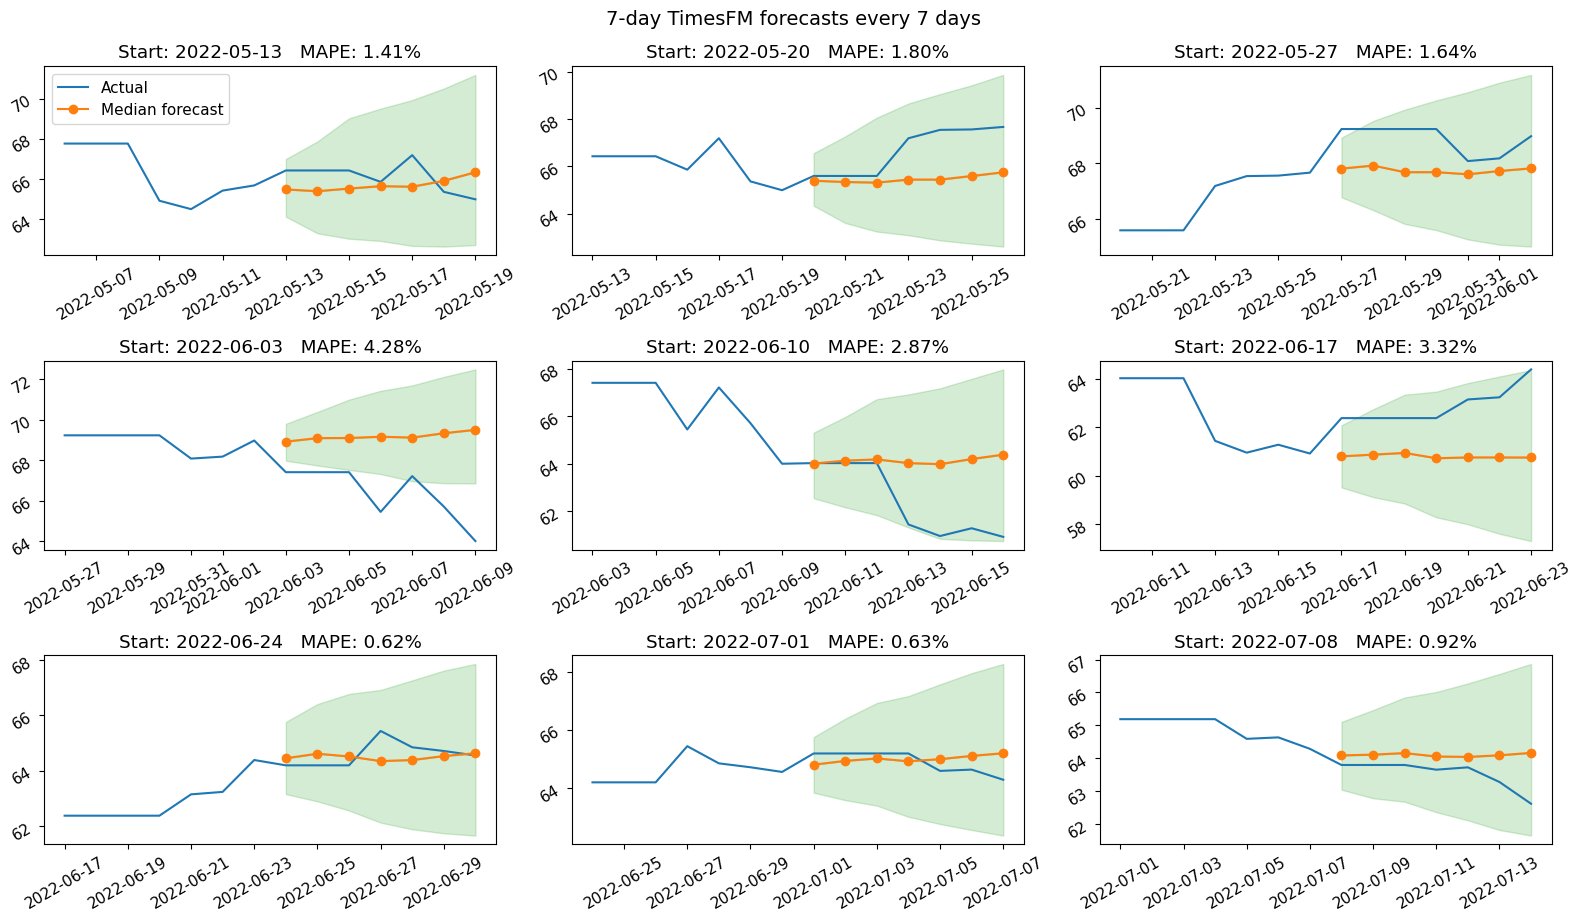

Average 7-day MAPE across windows: 1.94%


In [10]:
zs_forecasts = []   # each element: forecast DataFrame with columns ['ds','timesfm-q-0.1','timesfm-q-0.5','timesfm-q-0.9']
zs_actuals   = []   # each element: DataFrame with actual values for week of the forecast ['ds','value']
zs_prevweek  = []   # each element: DataFrame with actual values for week prior to the forecast ['ds','value']
zs_mapes     = []   # MAPEs for each window

for period_start in test_periods:
    # 1. history (all data < period_start)
    history = df[df['ds'] < period_start].copy()
    if history.empty:
        print(f"Brak historii przed {period_start.date()}, pomijam.")
        continue

    # 2. forecast
    forecast_df = tfm_best.forecast_on_df(
        inputs=history,
        freq="1D",
        value_name="y",
        num_jobs=-1
    ).copy()

    # 3. taking only first 7 days of the forecast [period_start, period_start+7d)
    end_7d = period_start + pd.Timedelta(days=7)
    fc7 = forecast_df[
        (forecast_df['ds'] >= period_start) &
        (forecast_df['ds'] <  end_7d)
    ].sort_values('ds').reset_index(drop=True)

    if fc7.empty:
        print(f"Brak prognozy w oknie {period_start.date()} – {end_7d.date()}, pomijam.")
        continue

    # 4. actual values in the week of the current forecast
    act7 = df[
        (df['ds'] >= period_start) &
        (df['ds'] <  end_7d)
    ].sort_values('ds').reset_index(drop=True)
    if act7.empty:
        print(f"Brak realnych danych w oknie {period_start.date()} – {end_7d.date()}, pomijam.")
        continue

    # 5. actual values in the week prior to the current forecast
    prev_start = period_start - pd.Timedelta(days=7)
    prev7 = df[
        (df['ds'] >= prev_start) &
        (df['ds'] <  period_start)
    ].sort_values('ds').reset_index(drop=True)
    if prev7.empty:
        prev7 = pd.DataFrame({'ds': [], 'y': []})

    # 6. fitting predicted and actual data
    merged = pd.merge_asof(
        act7[['ds','y']].sort_values('ds'),
        fc7[['ds','timesfm-q-0.1','timesfm-q-0.5','timesfm-q-0.9']].sort_values('ds'),
        on='ds',
        direction='nearest',
        tolerance=pd.Timedelta('1D')
    ).dropna(subset=['y','timesfm-q-0.5'])
    if merged.empty:
        print(f"Brak dopasowanych pikseli w oknie {period_start.date()}, pomijam.")
        continue

    # 7. MAPE for median values
    mape = mean_absolute_percentage_error(merged['y'], merged['timesfm-q-0.5']) * 100
    zs_mapes.append(mape)

    # 8. storing results
    zs_forecasts.append(fc7.copy())
    zs_actuals.append(act7[['ds','y']].copy())
    zs_prevweek.append(prev7[['ds','y']].copy())

    print(f"Window start {period_start.date():%Y-%m-%d} – MAPE: {mape:.2f}%")

# 9. visualization
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

n_windows = len(zs_forecasts)
ncols = 3
nrows = int(np.ceil(n_windows / ncols))

for idx in range(n_windows):
    ax = plt.subplot(nrows, ncols, idx + 1)

    fc7   = zs_forecasts[idx]
    act7  = zs_actuals[idx]
    prev7 = zs_prevweek[idx]
    start_date = test_periods[idx]
    mape = zs_mapes[idx]

    combined = pd.concat([prev7, act7]).sort_values('ds')
    ax.plot(combined['ds'], combined['y'], linestyle='-', color='C0', label='Actual')
    ax.plot(fc7['ds'], fc7['timesfm-q-0.5'], color='C1', marker='o', label='Median forecast')
    # confidence intervals
    ax.fill_between(
        fc7['ds'],
        fc7['timesfm-q-0.1'],
        fc7['timesfm-q-0.5'],
        alpha=0.2,
        color='C2'
    )
    ax.fill_between(
        fc7['ds'],
        fc7['timesfm-q-0.5'],
        fc7['timesfm-q-0.9'],
        alpha=0.2,
        color='C2'
    )

    ax.set_title(f"Start: {start_date.date()}   MAPE: {mape:.2f}%")
    ax.tick_params(labelrotation=30)
    if idx == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.suptitle("7-day TimesFM forecasts every 7 days\n", y=1.02, fontsize=14)
plt.show()

print(f"Average 7-day MAPE across windows: {np.mean(zs_mapes):.2f}%")


## Long-horizon forecast (full test set)

In [11]:
hparams = timesfm.TimesFmHparams(
    backend="gpu",
    per_core_batch_size=study.best_params["per_core_batch_size"],
    context_len=study.best_params["context_len"],
    horizon_len=1608,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=50,
    model_dims=1280,
    use_positional_embedding=False,
)
tfm_best = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

full_train = df.iloc[:valid_end]
print(full_train.tail(5))

forecast_df = tfm_best.forecast_on_df(
        inputs=full_train,
        freq="1D",
        value_name="y",
        num_jobs=-1
    )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

                             ds          y unique_id
10449 2022-03-22 00:00:00-04:00  77.516624       eqr
10450 2022-03-23 00:00:00-04:00  76.935928       eqr
10451 2022-03-24 00:00:00-04:00  77.516624       eqr
10452 2022-03-25 00:00:00-04:00  78.885727       eqr
10453 2022-03-26 00:00:00-04:00  78.885727       eqr
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


                             ds          y unique_id
10004 2021-01-01 00:00:00-05:00  50.610485       eqr
10005 2021-01-02 00:00:00-05:00  50.610485       eqr
10006 2021-01-03 00:00:00-05:00  50.610485       eqr
10007 2021-01-04 00:00:00-05:00  49.090809       eqr
10008 2021-01-05 00:00:00-05:00  48.706623       eqr
...                         ...        ...       ...
10449 2022-03-22 00:00:00-04:00  77.516624       eqr
10450 2022-03-23 00:00:00-04:00  76.935928       eqr
10451 2022-03-24 00:00:00-04:00  77.516624       eqr
10452 2022-03-25 00:00:00-04:00  78.885727       eqr
10453 2022-03-26 00:00:00-04:00  78.885727       eqr

[450 rows x 3 columns]


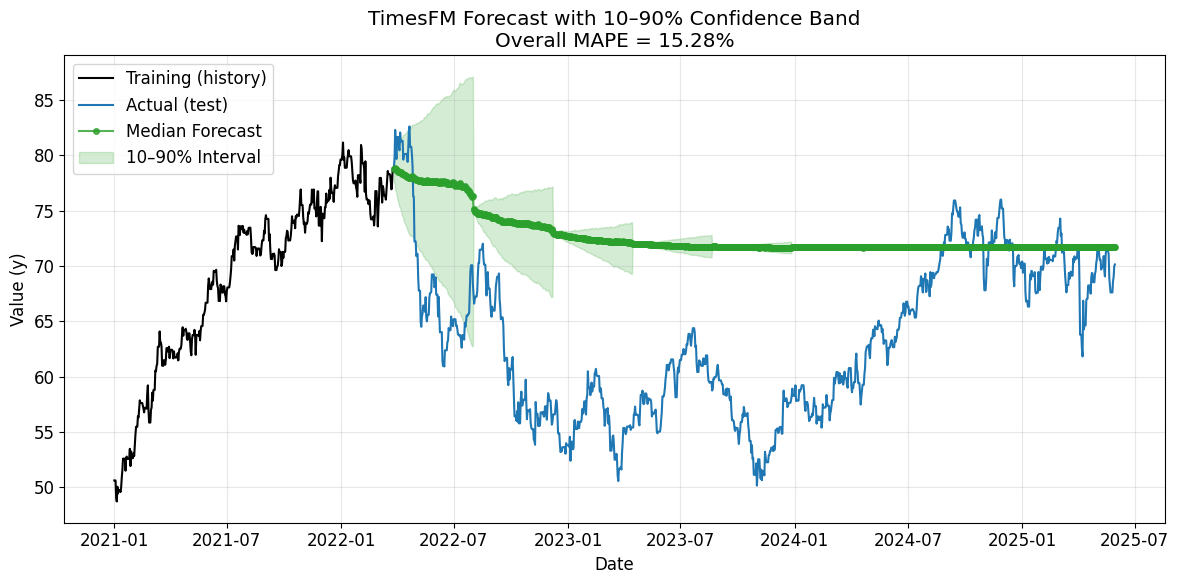

In [12]:
# 1. merge “forecast_df” with “df_test” on exact “ds” to get median + quantiles aligned with actuals:
merged = pd.merge(
    test_df[['ds', 'y']].rename(columns={'y': 'actual'}),
    forecast_df[['ds', 'timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9']],
    on='ds',
    how='inner'
)

# 2. compute overall MAPE (in percent) between actual and median forecast:
mape_overall = mean_absolute_percentage_error(
    merged['actual'],
    merged['timesfm-q-0.5']
) * 100

last_test_date = test_df['ds'].max()

mask_forecast_to_test = forecast_df['ds'] <= last_test_date
forecast_df = forecast_df.loc[mask_forecast_to_test].copy()

history   = df[(df['ds'] <= valid_df['ds'].max()) & (df['ds'] > '2021-01-01 00:00:00-04:00')]
print(history)


# 3. plot everything in one figure:
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

# 3a) plot the historical training series as a solid black line:
plt.plot(
    history['ds'],
    history['y'],
    color='black',
    linewidth=1.5,
    label='Training (history)'
)

# 3b) plot the actual test series as a solid blue line:
plt.plot(
    test_df['ds'],
    test_df['y'],
    color='C0',
    linewidth=1.5,
    label='Actual (test)'
)

# 3c) plot the median forecast (timesfm-q-0.5) as a green line with markers:
plt.plot(
    forecast_df['ds'],
    forecast_df['timesfm-q-0.5'],
    color='C2',
    linestyle='-',
    linewidth=1.5,
    alpha=0.8,
    marker='o',
    markersize=4,
    label='Median Forecast'
)

# 3d) draw the 10–90 % confidence band (shaded area) in light green:
plt.fill_between(
    forecast_df['ds'].values,
    forecast_df['timesfm-q-0.1'].values,
    forecast_df['timesfm-q-0.9'].values,
    color='C2',
    alpha=0.2,
    label='10–90% Interval'
)

# 4. formatting:
plt.xlabel('Date')
plt.ylabel('Value (y)')
plt.title(f'TimesFM Forecast with 10–90% Confidence Band\nOverall MAPE = {mape_overall:.2f}%')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
max_idx = forecast_df['timesfm-q-0.9'].idxmax()
max_date = forecast_df.loc[max_idx, 'ds']

print(f"Highest 90% quantile occurs on: {max_date}")

Highest 90% quantile occurs on: 2022-08-01 00:00:00-04:00
